In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from telfit import Modeler

import scipy.ndimage as scipynd
from scipy.optimize import curve_fit
from astropy import  convolution


DEIMOS_DROPBOX = '/Users/mgeha/Dropbox/DEIMOS/'


In [3]:
# RUN TELFIT SOFTWARE
# INSTALLED FROM https://github.com/freddavies/Telluric-Fitter-py3
# 
def run_telfit(h2o,o2):
    
    # DEIMOS WAVELENGTH RANGE
    wave_deimos = np.arange(6200,9500,0.01)  # DEFINE 0.01A GRID

    # HARDWIRE TO MAUNA KEA
    alt = 4.2
    lat = 19.8

    # START/END WAVELENGTH IN NM
    wavestart = 620.0
    waveend   = 950.0
       
    #GENERATE A TELLURIC SPECTRUM -- DEFAULT RESOLUTION 0.001AA
    modeler = Modeler()
    print(h2o,o2)
    model = modeler.MakeModel(humidity=h2o,o2=o2,
                          lowfreq=1e7/waveend,
                          highfreq=1e7/wavestart, lat=lat, alt=alt)

    tell = model.toarray()

    # CONVERT TO ANGSTRUM
    wave = 10. * tell[:,0]
    flux = tell[:,1]
    
    # DETERMINE BINNING
    bins = wave - np.roll(wave,1) 
    print('binning = ',np.median(bins))
    
    
    # SMOOTH AND REBIN TO LINEAR 0.01A PIXELS
    sig_res = 0.01/np.median(bins)
    print('Kernal ',sig_res)
    gauss_kernel = convolution.Gaussian1DKernel(sig_res)
    smooth_flux  = convolution.convolve(flux, gauss_kernel)

    tell_flux = np.interp(wave_deimos,wave,smooth_flux)

    plt.plot(wave,flux)
    plt.plot(wave_deimos,tell_flux)
    plt.xlim(6900,6910)
    
    return tell_flux

In [4]:
# DEFINE 0.01A WAVELENGTH GRID
wave_deimos = np.arange(6200,9500,0.01)


In [19]:
# GRID OF PARAMETERS

# FAKE VALUES BETWEEN H2O = 38 to 44
# 44. = 45 
# 42 = 44.2 done
# 40 = 37. done
# 38 = 36.5

# COARSE GRID POINTS
#h2o_grid = 1.*np.arange(35,105,5)
#h2o_grid = 1.*np.arange(40,42,2)
#o2_grid  = 1.e5 * np.arange(0.6, 2.5,0.1)


# FINE GRID POINTS
o2_grid  = 1.e5 * np.arange(0.7, 2.1,0.05)
h2o_grid = 1.*np.arange(40,46,2) 


40.0 70000.0
37.1 70000.0
binning =  0.0017057856780411385
Kernal  5.862401196546352
/Users/mgeha/Dropbox/DEIMOS//templates/tmp_fine_tellurics/telluric_0.01A_h2o_40_o2_0.70_.fits
40.0 75000.0
37.1 75000.0
binning =  0.0017057856780411385
Kernal  5.862401196546352
/Users/mgeha/Dropbox/DEIMOS//templates/tmp_fine_tellurics/telluric_0.01A_h2o_40_o2_0.75_.fits
40.0 80000.0
37.1 80000.0
binning =  0.0017057856780411385
Kernal  5.862401196546352
/Users/mgeha/Dropbox/DEIMOS//templates/tmp_fine_tellurics/telluric_0.01A_h2o_40_o2_0.80_.fits
40.0 85000.00000000001
37.1 85000.00000000001
binning =  0.0017057856780411385
Kernal  5.862401196546352
/Users/mgeha/Dropbox/DEIMOS//templates/tmp_fine_tellurics/telluric_0.01A_h2o_40_o2_0.85_.fits
40.0 90000.00000000001
37.1 90000.00000000001
binning =  0.0017057856780411385
Kernal  5.862401196546352
/Users/mgeha/Dropbox/DEIMOS//templates/tmp_fine_tellurics/telluric_0.01A_h2o_40_o2_0.90_.fits
40.0 95000.00000000001
37.1 95000.00000000001
binning =  0.001705

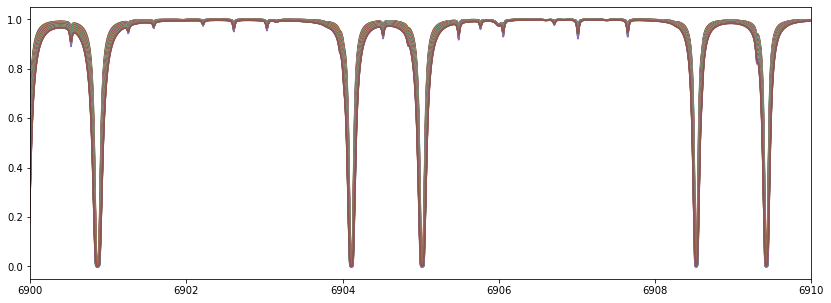

In [20]:
plt.figure(figsize=(14,5))

for h2o in h2o_grid:
    th2o = h2o
    if (h2o ==40):
        th2o=37.1
    for o2 in o2_grid:

        # EXTRA '_' for reading purposes
        outname = DEIMOS_DROPBOX + '/templates/fine_tellurics/telluric_0.01A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2/1.e5)

        print(h2o,o2)
        
        twave = wave_deimos
        if not os.path.isfile(outname):
            tflux = run_telfit(th2o,o2)
            print(outname)

            t = Table([twave,tflux], names=('wave', 'flux'))
            t.meta['h2o'] = h2o
            t.meta['o2']  = o2

            t.write(outname, format='fits')

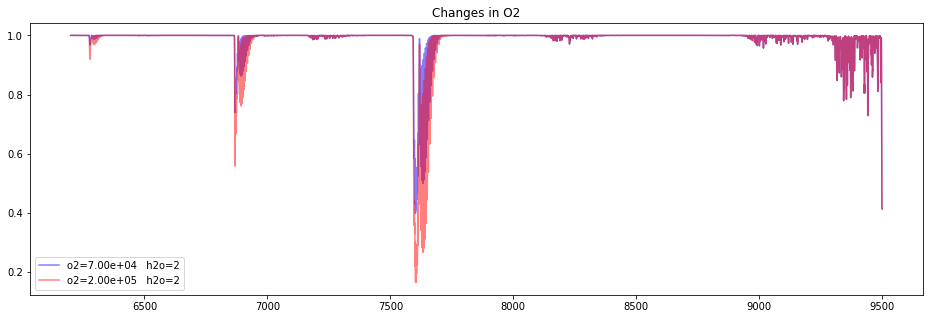

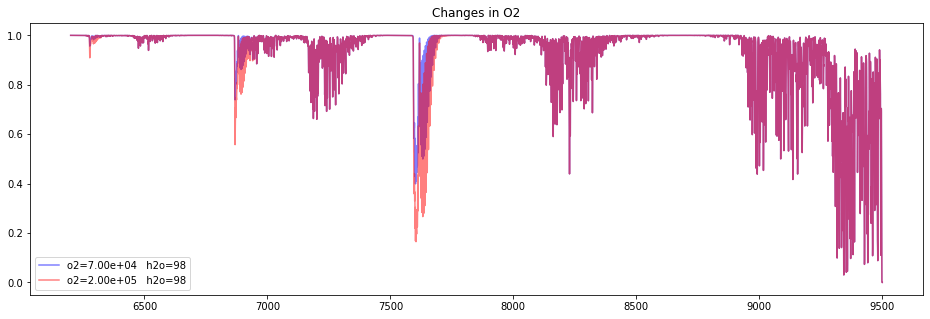

In [27]:
clr = ['blue','red']
o2_val  = 1.e5 * np.array([0.7,2.0])
h2o_val = np.array([2,98])
losvd_pix = 0.5/0.01

for h2o in h2o_val:
    
    plt.figure(figsize=(16,5))
    for o2,c in zip(o2_val,clr):
        tfile = DEIMOS_DROPBOX + '/templates/fine_tellurics/telluric_0.01A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2/1.e5)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        t = 'o2={:0.2e}   h2o={:0.0f}'.format(o2,h2o)
        plt.plot(twave,cflux,alpha=0.5,label=t,color=c)
        plt.title('Changes in O2')

    plt.legend()
#plt.xlim(8200,8500)

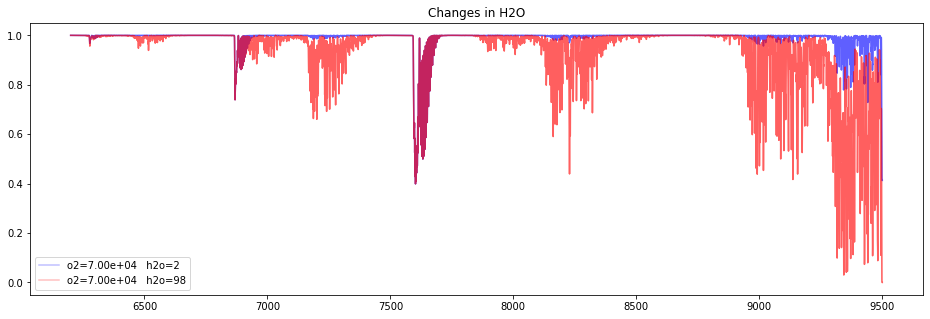

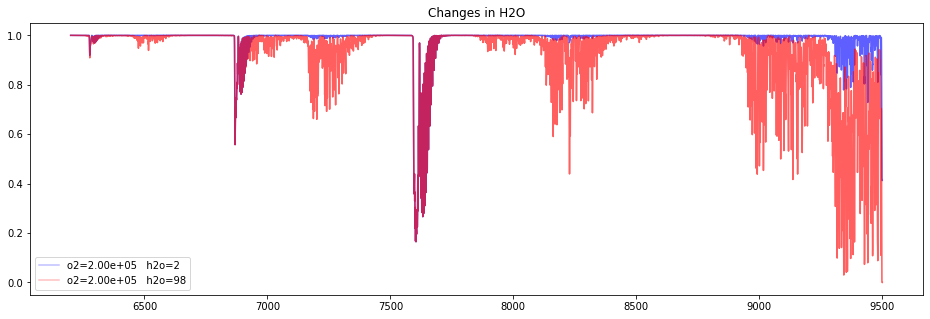

In [28]:
clr = ['blue','red']

for o2 in o2_val:
    
    plt.figure(figsize=(16,5))
    for h2o,c in zip(h2o_val,clr):
        tfile = DEIMOS_DROPBOX + '/templates/fine_tellurics/telluric_0.01A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2/1.e5)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

 
        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        plt.plot(twave,cflux,alpha=0.5,color=c)
        t = 'o2={:0.2e}   h2o={:0.0f}'.format(o2,h2o)
        plt.plot(twave,cflux,alpha=0.25,label=t,color=c)
        plt.title('Changes in H2O')
    plt.legend()
   # plt.xlim(8100,8350)